## Baseline Comparison for Cow Health Anomaly Detection

This notebook compares the proposed body-part–specific GMM anomaly detection
method against simple and classical unsupervised baselines:
1. Global temperature thresholding
2. One-Class SVM (OC-SVM)

The goal is to contextualize the proposed method, not to optimize supervised accuracy.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# plotting style (keep consistent)
sns.set_style("whitegrid")


In [8]:
df = pd.read_csv("final_cow_thermal_dataset.csv")

# Safety cleanup
df = df.drop(columns=["sample_folder"], errors="ignore")

print(df.shape)
df.head()


(51948, 11)


,cow_part,ambient_temp,humidity,mean_temp,max_temp,frame_std,delta_mean,delta_max,lactation,health_state,season
0,etc,17.6,83.2,24.34,26.05,3.20,6.74,8.45,0,healthy,winter
1,etc,17.0,82.9,23.66,26.15,3.02,6.66,9.15,0,healthy,winter
2,etc,16.9,83.7,22.76,26.13,2.82,5.86,9.23,0,healthy,winter
3,etc,16.8,84.2,22.34,24.84,2.81,5.54,8.04,0,healthy,winter
4,etc,16.8,84.2,22.14,25.42,2.90,5.34,8.62,0,healthy,winter


In [9]:
FEATURES = [
    "delta_mean",
    "delta_max",
    "frame_std",
    "humidity"
]


In [10]:
import joblib
import json
import os

gmm_models = {}
scalers = {}

# Load models
for fname in os.listdir("artifacts/gmm_models"):
    part = fname.replace("gmm_", "").replace(".joblib", "")
    gmm_models[part] = joblib.load(f"artifacts/gmm_models/{fname}")

# Load scalers
for fname in os.listdir("artifacts/scalers"):
    part = fname.replace("scaler_", "").replace(".joblib", "")
    scalers[part] = joblib.load(f"artifacts/scalers/{fname}")

# Load thresholds
with open("artifacts/config/thresholds.json", "r") as f:
    thresholds = json.load(f)

print("✅ Loaded GMM models:", list(gmm_models.keys()))


✅ Loaded GMM models: ['etc', 'eye', 'hoof', 'leg', 'udder']


In [11]:
FEATURES = [
    "delta_mean",
    "delta_max",
    "frame_std",
    "humidity"
]

def compute_gmm_score(row):
    part = row["cow_part"]
    if part not in gmm_models:
        return None

    x = pd.DataFrame([row[FEATURES]], columns=FEATURES)
    x_scaled = scalers[part].transform(x)
    return gmm_models[part].score_samples(x_scaled)[0]

df["gmm_score"] = df.apply(compute_gmm_score, axis=1)


In [12]:
def flag_abnormal(row):
    part = row["cow_part"]
    if part not in thresholds:
        return 0
    return int(row["gmm_score"] < thresholds[part])

df["abnormal"] = df.apply(flag_abnormal, axis=1)


### Baseline A: Global Temperature Threshold

A simple rule-based baseline that flags abnormality if the
ambient-normalized mean temperature exceeds a fixed threshold.
This mimics common farm practices.


In [13]:
healthy_global = df[df["health_state"] == "healthy"]["delta_mean"]

# Conservative threshold
global_threshold = np.percentile(healthy_global, 95)

print("Global Δmean threshold:", round(global_threshold, 2))

df["abnormal_global"] = (
    df["delta_mean"] > global_threshold
).astype(int)


Global Δmean threshold: 13.14


### Baseline B: One-Class SVM

A classical unsupervised anomaly detection model trained only on
healthy physiological data.


In [14]:
# Train on healthy data only
train_oc = df[df["health_state"] == "healthy"][FEATURES]

scaler_oc = StandardScaler()
X_train_oc = scaler_oc.fit_transform(train_oc)

ocsvm = OneClassSVM(
    kernel="rbf",
    nu=0.05,        # matches 5% anomaly assumption
    gamma="scale"
)

ocsvm.fit(X_train_oc)

# Apply to all data
X_all_oc = scaler_oc.transform(df[FEATURES])
oc_pred = ocsvm.predict(X_all_oc)

# -1 = anomaly
df["abnormal_ocsvm"] = (oc_pred == -1).astype(int)


In [15]:
comparison = pd.DataFrame({
    "Proposed (GMM)": df.groupby("health_state")["abnormal"].mean(),
    "Global Threshold": df.groupby("health_state")["abnormal_global"].mean(),
    "OC-SVM": df.groupby("health_state")["abnormal_ocsvm"].mean()
})

comparison


,Proposed (GMM),Global Threshold,OC-SVM
health_state,,,
fever,0.550333,0.000000,0.188667
healthy,0.050204,0.049967,0.049967
lameness,0.991935,0.000000,0.884140
mastitis,0.889000,0.941667,0.887333


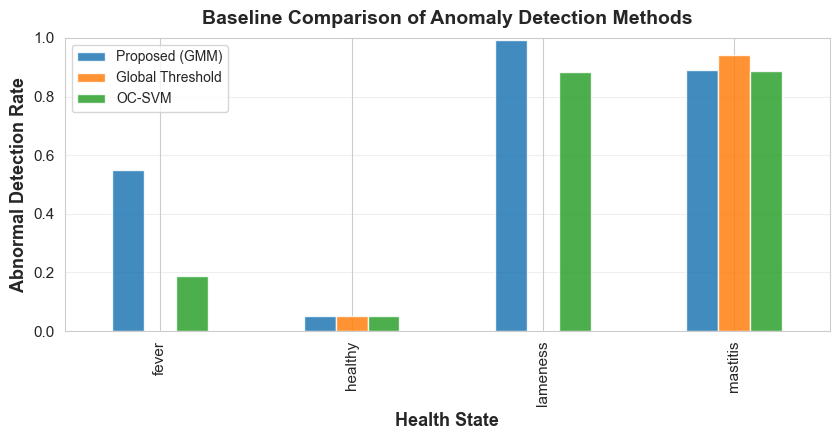

In [17]:
comparison.plot(
    kind="bar",
    figsize=(8.5,4.5),
    ylim=(0,1),
    alpha=0.85
)

plt.ylabel("Abnormal Detection Rate", fontsize=13, fontweight="bold")
plt.xlabel("Health State", fontsize=13, fontweight="bold")
plt.title(
    "Baseline Comparison of Anomaly Detection Methods",
    fontsize=14,
    fontweight="bold",
    pad=10
)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
